In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distanc

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
dataset_name = 'scMultiSim-1250'
dataset_color = 'teal'
modality_names = ['Modality 1', 'Modality 2']
data_folder = '../data/scMultiSim/new/'
data1 = np.loadtxt(data_folder + "scMultiSim_RNA_counts_1250_genes.csv", delimiter=",", skiprows=1)
data2 = np.loadtxt(data_folder + "scMultiSim_ATAC_seq_1250_genes_new.csv", delimiter=",", skiprows=1)
ct = pd.read_csv(data_folder + "cell_meta_1250_genes.csv").iloc[3, 1:].to_numpy().astype(int)
type1 = type2 = np.array([f'Cell Type {i:>2}' for i in ct])

# Labels
labels = [type1, type2]
features = [None, None]
feature_dict = {}

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
### ALWAYS RUN FOR LOSS GRAPH
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str) and False:
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0025  Rec: 1.1088  CosSim: 0.0667  F: 0.0054
Epoch: 200 - KL: 0.0041  Rec: 0.9327  CosSim: 0.0383  F: 0.0052
Epoch: 300 - KL: 0.0066  Rec: 0.8625  CosSim: 0.0320  F: 0.0053
Epoch: 400 - KL: 0.0092  Rec: 0.8169  CosSim: 0.0295  F: 0.0053
Epoch: 500 - KL: 0.0135  Rec: 0.7924  CosSim: 0.0270  F: 0.0052
epoch:[500/10000]: loss:0.838001
Epoch: 600 - KL: 0.0183  Rec: 0.7631  CosSim: 0.0247  F: 0.0047
Epoch: 700 - KL: 0.0278  Rec: 0.7437  CosSim: 0.0252  F: 0.0045
Epoch: 800 - KL: 0.0445  Rec: 0.7326  CosSim: 0.0255  F: 0.0046
Epoch: 900 - KL: 0.0366  Rec: 0.7180  CosSim: 0.0260  F: 0.0044
Epoch: 1000 - KL: 0.0704  Rec: 0.7155  CosSim: 0.0265  F: 0.0043
epoch:[1000/10000]: loss:0.816653
Epoch: 1100 - KL: 0.0726  Rec: 0.7089  CosSim: 0.0291  F: 0.0045
Epoch: 1200 - KL: 0.1076  Rec: 0.7058  CosSim: 0.0324  F: 0.0045
Epoch: 1300 - KL: 0.1369  Rec: 0.6849  CosSim: 0.0339  F: 0.0046
Epoch: 1400 - KL: 0.1295  Rec: 0.6875  CosSim: 0.0407  F: 0.0048
Epoch: 1500 - KL: 0.1522  Rec: 0

In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0015  Rec: 1.0952  CosSim: 0.0690  F: 0.0075
Epoch: 200 - KL: 0.0023  Rec: 0.9266  CosSim: 0.0368  F: 0.0060
Epoch: 300 - KL: 0.0023  Rec: 0.8630  CosSim: 0.0313  F: 0.0064
Epoch: 400 - KL: 0.0034  Rec: 0.8149  CosSim: 0.0282  F: 0.0062
Epoch: 500 - KL: 0.0030  Rec: 0.7836  CosSim: 0.0271  F: 0.0064
epoch:[500/10000]: loss:0.820066
Epoch: 600 - KL: 0.0046  Rec: 0.7618  CosSim: 0.0257  F: 0.0065
Epoch: 700 - KL: 0.0061  Rec: 0.7472  CosSim: 0.0249  F: 0.0058
Epoch: 800 - KL: 0.0076  Rec: 0.7350  CosSim: 0.0227  F: 0.0059
Epoch: 900 - KL: 0.0058  Rec: 0.7191  CosSim: 0.0254  F: 0.0061
Epoch: 1000 - KL: 0.0098  Rec: 0.7194  CosSim: 0.0389  F: 0.0063
epoch:[1000/10000]: loss:0.774272
Epoch: 1100 - KL: 0.0124  Rec: 0.6936  CosSim: 0.0239  F: 0.0064
Epoch: 1200 - KL: 0.0106  Rec: 0.6789  CosSim: 0.0245  F: 0.0066
Epoch: 1300 - KL: 0.0086  Rec: 0.6709  CosSim: 0.0266  F: 0.0065
Epoch: 1400 - KL: 0.0073  Rec: 0.6658  CosSim: 0.0300  F: 0.0071
Epoch: 1500 - KL: 0.0050  Rec: 0

In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0017  Rec: 1.0563  CosSim: 0.0596  F: 0.0113
Epoch: 200 - KL: 0.0023  Rec: 0.9085  CosSim: 0.0324  F: 0.0089
Epoch: 300 - KL: 0.0026  Rec: 0.8452  CosSim: 0.0258  F: 0.0089
Epoch: 400 - KL: 0.0036  Rec: 0.8107  CosSim: 0.0244  F: 0.0077
Epoch: 500 - KL: 0.0037  Rec: 0.7827  CosSim: 0.0240  F: 0.0078
epoch:[500/10000]: loss:0.818276
Epoch: 600 - KL: 0.0048  Rec: 0.7612  CosSim: 0.0231  F: 0.0081
Epoch: 700 - KL: 0.0030  Rec: 0.7431  CosSim: 0.0224  F: 0.0069
Epoch: 800 - KL: 0.0067  Rec: 0.7258  CosSim: 0.0188  F: 0.0068
Epoch: 900 - KL: 0.0064  Rec: 0.7162  CosSim: 0.0212  F: 0.0076
Epoch: 1000 - KL: 0.0101  Rec: 0.6996  CosSim: 0.0215  F: 0.0075
epoch:[1000/10000]: loss:0.738661
Epoch: 1100 - KL: 0.0081  Rec: 0.6882  CosSim: 0.0208  F: 0.0077
Epoch: 1200 - KL: 0.0077  Rec: 0.6845  CosSim: 0.0218  F: 0.0082
Epoch: 1300 - KL: 0.0071  Rec: 0.6754  CosSim: 0.0233  F: 0.0077
Epoch: 1400 - KL: 0.0071  Rec: 0.6714  CosSim: 0.0274  F: 0.0082
Epoch: 1500 - KL: 0.0092  Rec: 0

In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (400, 1250)
Dataset 1: (400, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.1823 alpha:0.1030
epoch:[1000/2000] err:13.5529 alpha:0.2266
epoch:[1500/2000] err:16.9948 alpha:0.5188
epoch:[2000/2000] err:18.5696 alpha:0.8820
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 400, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 400, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0018  Rec: 1.1411  CosSim: 0.0995  F: 0.0060
Epoch: 200 - KL: 0.0036  Rec: 0.9885  CosSim: 0.0517  F: 0.0056
Epoch: 300 - KL: 0.0059  Rec: 0.9223  CosSim: 0.0438  F: 0.0062
Epoch: 400 - KL: 0.0097  Rec: 0.8772  CosSim: 0.0384  F: 0.0056
Epoch: 500 - KL: 0.0147  Rec: 0.8475  CosSim: 0.0354  F: 0.0054
epoch:[500/10000]: loss:0.903115
Epoch: 600 - KL: 0.0216  Rec: 0.8185  CosSim: 0.0355  F: 0.0055
Epoch: 700 - KL: 0.0231  Rec: 0.8109  CosSim: 0.0348  F: 0.0053
Epoch: 800 - KL: 0.0395  Rec: 0.7784  CosSim: 0.0331  F: 0.0055
Epoch: 900 - KL: 0.0532  Rec: 0.7639  CosSim: 0.0349  F: 0.0055
Epoch: 1000 - KL: 0.0594  Rec: 0.7565  CosSim: 0.0367  F: 0.0053
epoch:[1000/10000]: loss:0.857979
Epoch: 1100 - KL: 0.0898  Rec: 0.7519  CosSim: 0.0384  F: 0.0052
Epoch: 1200 - KL: 0.0879  Rec: 0.7421  CosSim: 0.0391  F: 0.0055
Epoch: 1300 - KL: 0.1215  Rec: 0.7267  CosSim: 0.0411  F: 0.0056
Epoch: 1400 - KL: 0.1219  Rec: 0.7182  CosSim: 0.0413  F: 0.0056
Epoch: 1500 - KL: 0.1679  Rec: 0

# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [14]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [15]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [16]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

2023-09-02 13:45:44.406993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-02 13:45:44.407686: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-02 13:45:44.407721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2023-09-02 13:45:44.408794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 13:45:44.423416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:

In [17]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:82.0075 alpha:9.8663
epoch:[200/2000] err:10.9873 alpha:1.3219
epoch:[300/2000] err:8.3727 alpha:0.8845
epoch:[400/2000] err:6.8403 alpha:1.0824
epoch:[500/2000] err:5.3734 alpha:1.3768
epoch:[600/2000] err:4.6431 alpha:1.6009
epoch:[700/2000] err:4.3510 alpha:1.7600
epoch:[800/2000] err:4.2306 alpha:1.8822
epoch:[900/2000] err:4.1723 alpha:1.9834
epoch:[1000/2000] err:4.1448 alpha:2.0721
epoch:[1100/2000] err:4.1387 alpha:2.1516
epoch:[1200/2000] err:4.1476 alpha:2.2222
epoch:[1300/2000] err:4.1601 alpha:2.2853
epoch:[1400/2000] err:4.1672 alpha:2.3420
epoch:[1500/2000] err:4.1493 alpha:2.3936
epoch:[1600/2000] err:4.0735 alpha:2.4429
epoch:[1700/2000] err:3.9615 alpha:2.4892
epoch:[1800/2000] err:3.8687 alpha:2.5317
epoch:[1900/2000] err:3.8164 alpha:2.5696
epoch:[2000/2000] err:

In [18]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [19]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'svg.fonttype': 'none',
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

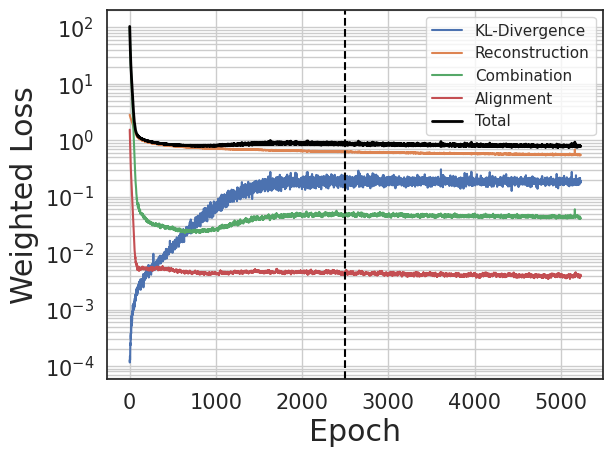

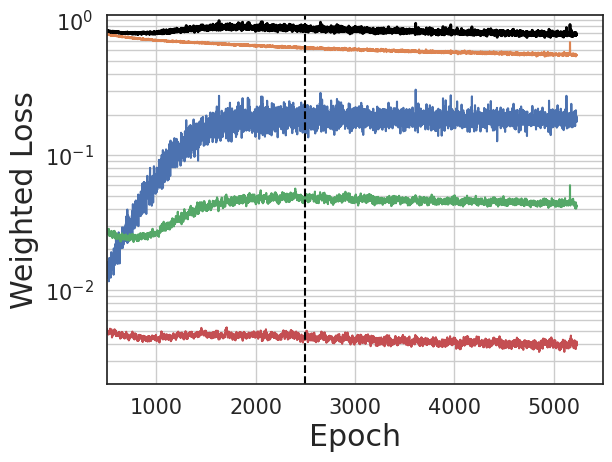

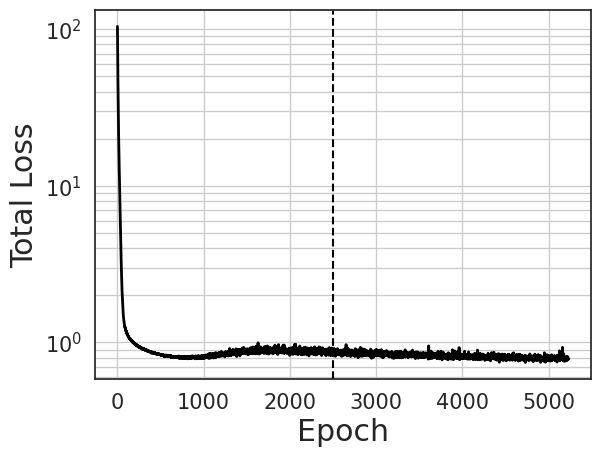

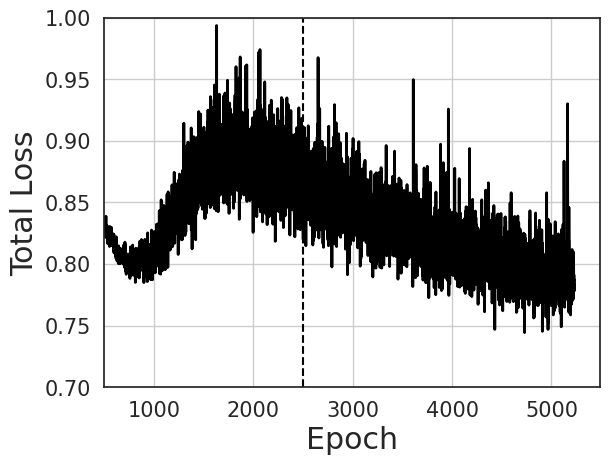

In [20]:
# Loss plot
for k, v in jm.loss_history.items():
    loss_name = {
        'KL': 'KL-Divergence',
        'Rec': 'Reconstruction',
        'CosSim': 'Combination',
        'F': 'Alignment'
    }[k]
    plt.plot(v, label=loss_name)
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Total', lw=2)
plt.axvline(x=2500, color='black', linestyle='--')
plt.grid(True, which="both")
plt.xlabel('Epoch')
plt.ylabel('Weighted Loss')
plt.yscale('log')
plt.legend()
plt.savefig(image_folder + dataset_name + f'-Loss.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + f'-Loss.svg', format='svg', bbox_inches='tight')
plt.show()

# Zoom
for k, v in jm.loss_history.items():
    loss_name = {
        'KL': 'KL-Divergence',
        'Rec': 'Reconstruction',
        'CosSim': 'Combination',
        'F': 'Alignment'
    }[k]
    plt.plot(v, label=loss_name)
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Total', lw=2)
plt.axvline(x=2500, color='black', linestyle='--')
plt.grid(True, which="both")
plt.xlabel('Epoch')
plt.ylabel('Weighted Loss')
plt.yscale('log')
plt.ylim([.002, 1.1])
plt.xlim([500, plt.gca().get_xlim()[1]])
plt.savefig(image_folder + dataset_name + f'-LossZoom.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + f'-LossZoom.svg', format='svg', bbox_inches='tight')
plt.show()

# Total Linear
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Total', lw=2)
plt.axvline(x=2500, color='black', linestyle='--')
plt.grid(True, which="both")
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.yscale('log')
plt.savefig(image_folder + dataset_name + f'-LossTotalLinear.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + f'-LossTotalLinear.svg', format='svg', bbox_inches='tight')
plt.show()

# Total Linear Zoom
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Total', lw=2)
plt.axvline(x=2500, color='black', linestyle='--')
plt.grid(True, which="both")
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.ylim([.7, 1.])
plt.xlim([500, plt.gca().get_xlim()[1]])
plt.savefig(image_folder + dataset_name + f'-LossTotalLinearZoom.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + f'-LossTotalLinearZoom.svg', format='svg', bbox_inches='tight')
plt.show()

In [21]:
sns.set_palette('husl', len(np.unique(labels)))

In [22]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-LabelLegend.svg', bbox_inches=bbox, format='svg')

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.svg', bbox_inches=bbox, format='svg')

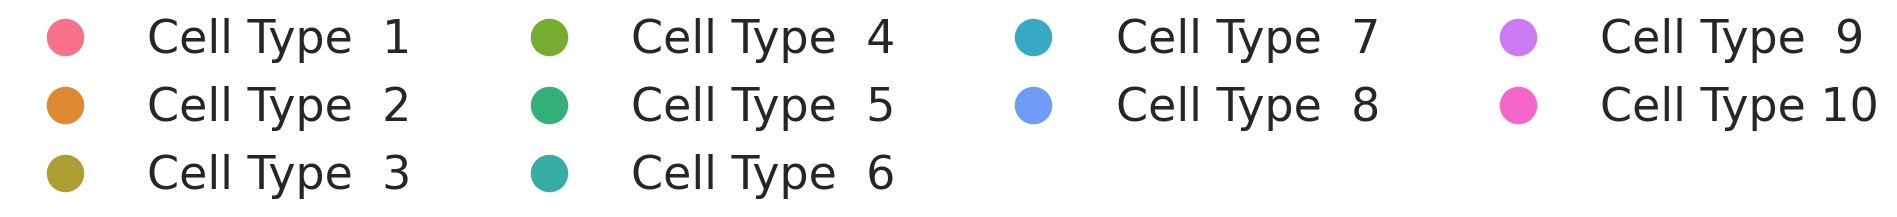

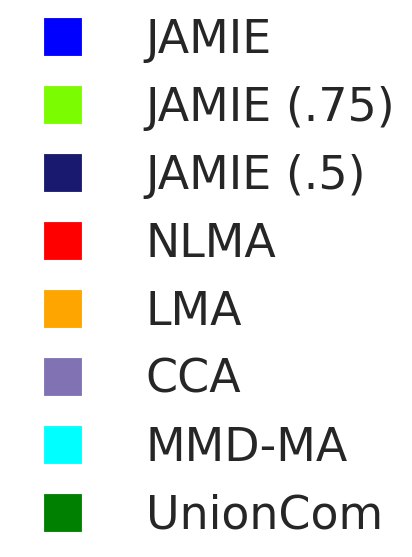

In [23]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

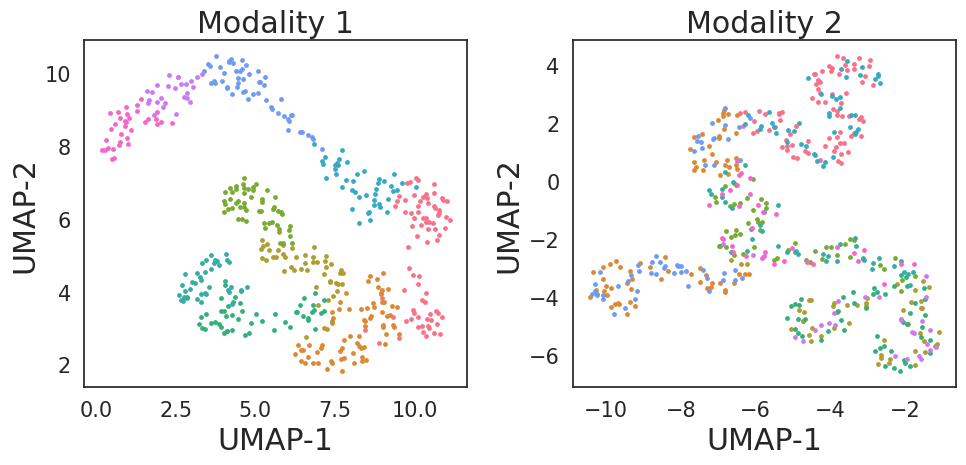

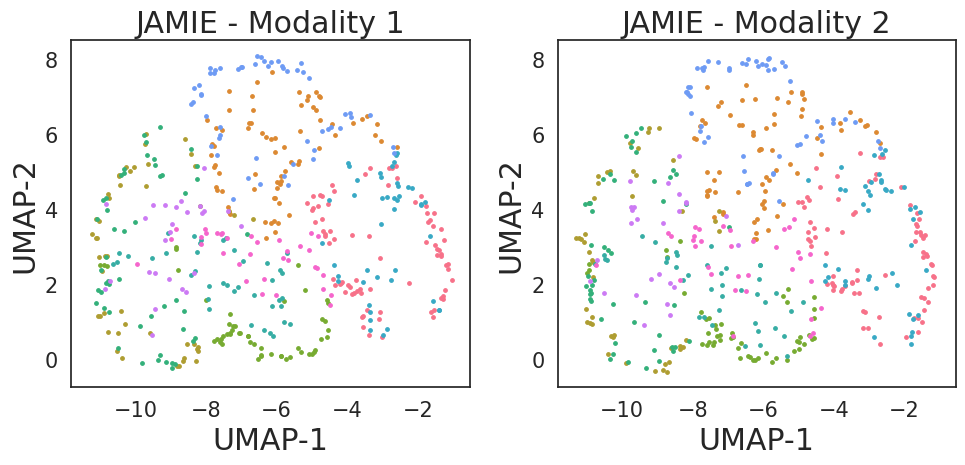

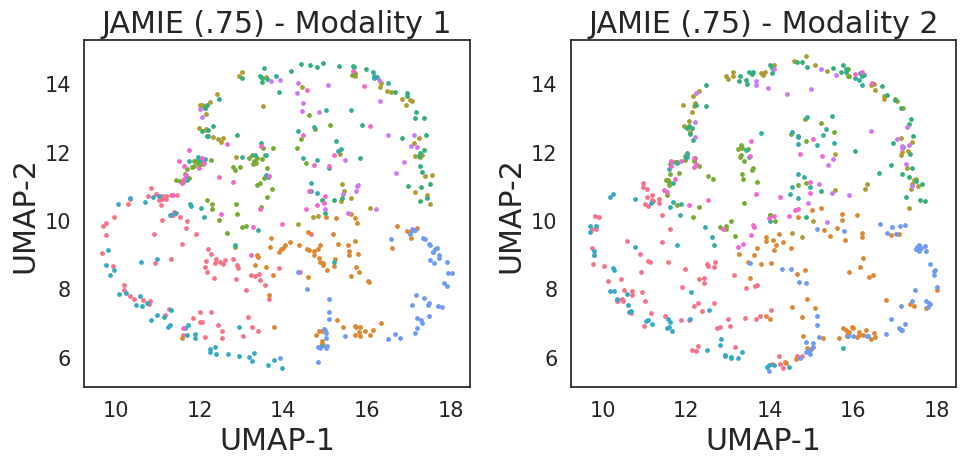

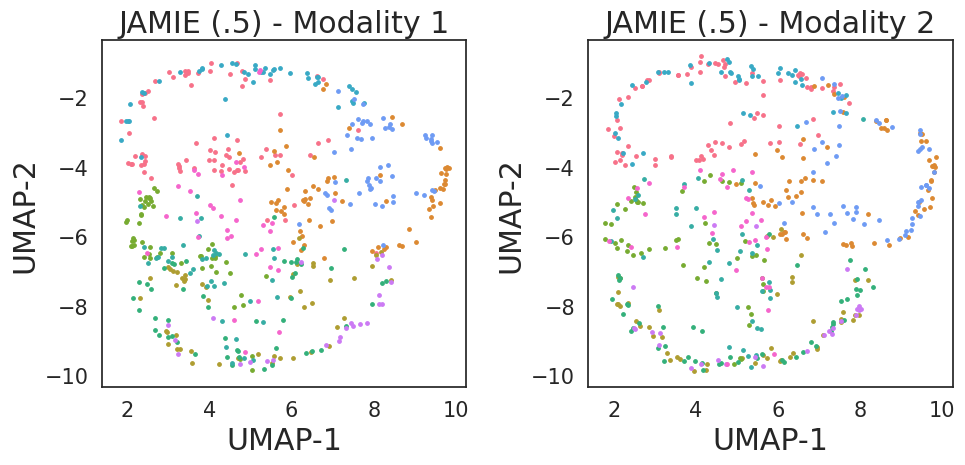

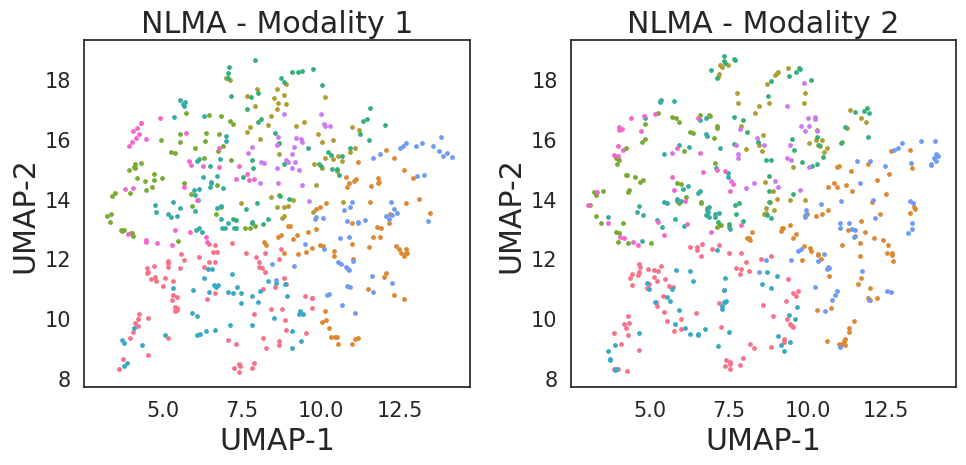

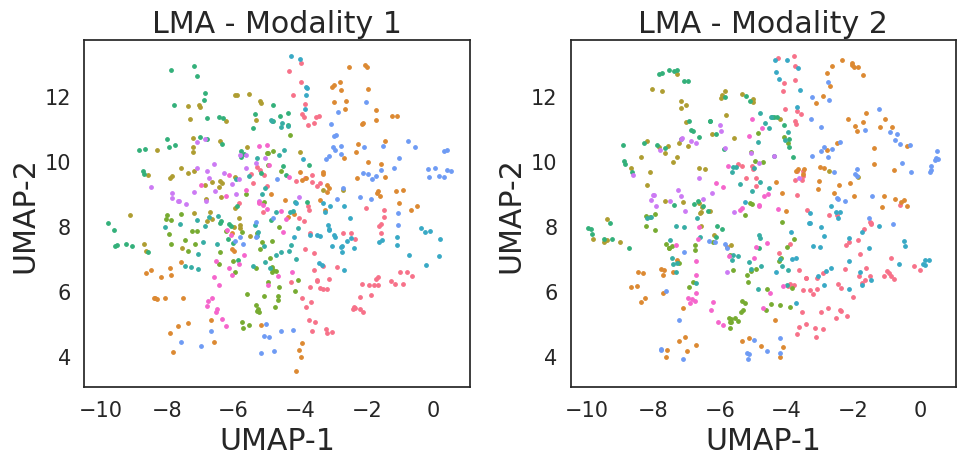

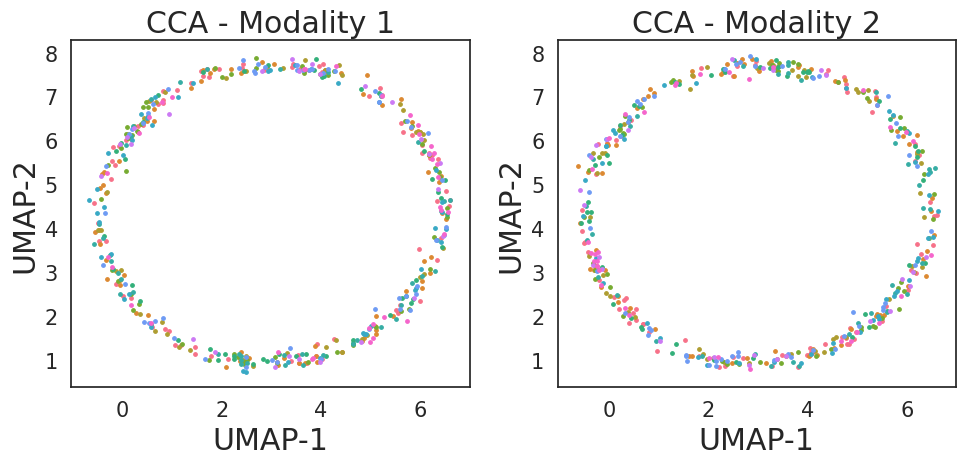

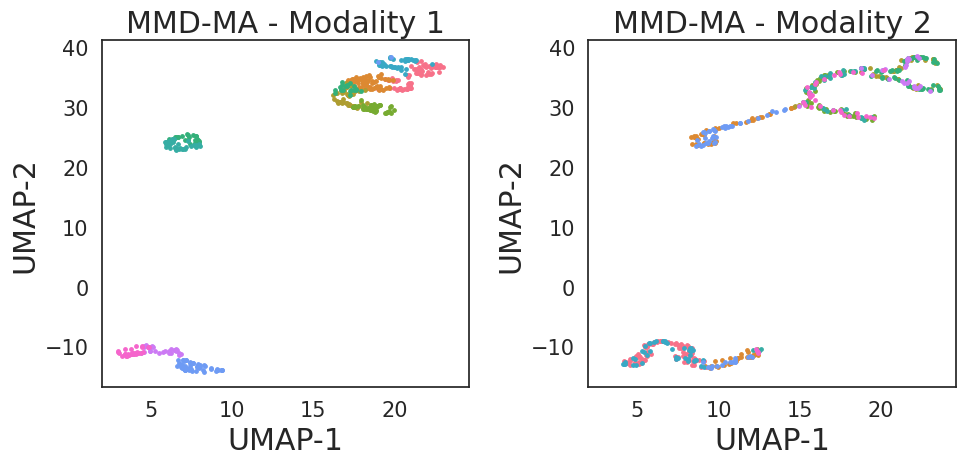

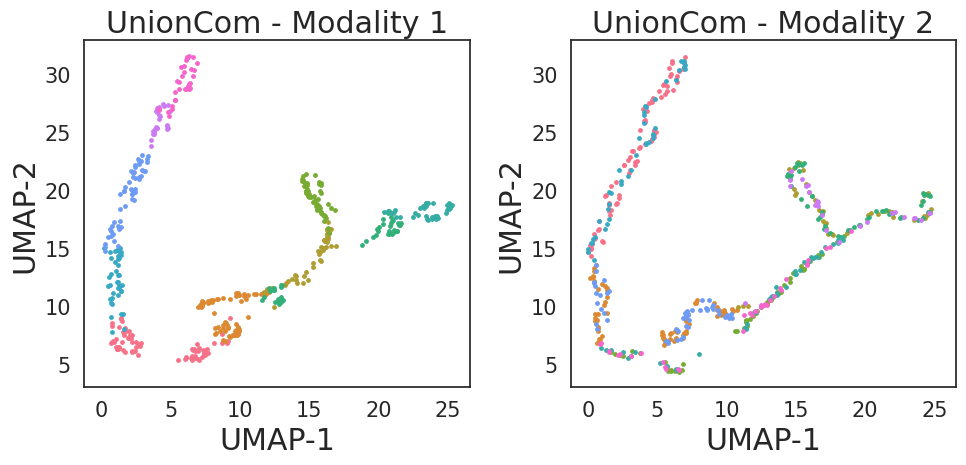

In [24]:
# Raw data
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Data.svg', format='svg', bbox_inches='tight')

# Integrated data
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.savefig(image_folder + dataset_name + f'-{n}.svg', format='svg', bbox_inches='tight')
    plt.show()

Algorithm     JAMIE     NLMA       LMA       CCA    MMD-MA  UnionCom
FOSCTTM    0.000322  0.00194  0.002018  0.954652  0.550786  0.431242
LTA        0.950000  0.88600  0.868000  0.158000  0.136000  0.052000
Algorithm     JAMIE  JAMIE (.75)  JAMIE (.5)     NLMA       LMA       CCA  \
FOSCTTM    0.000322     0.041262    0.108992  0.00194  0.002018  0.954652   
LTA        0.950000     0.874000    0.808000  0.88600  0.868000  0.158000   

Algorithm    MMD-MA  UnionCom  
FOSCTTM    0.550786  0.431242  
LTA        0.136000  0.052000  


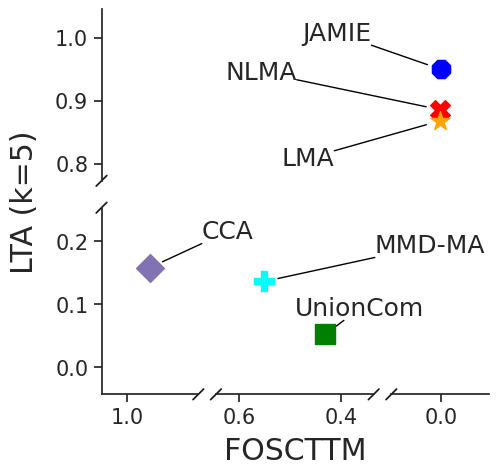

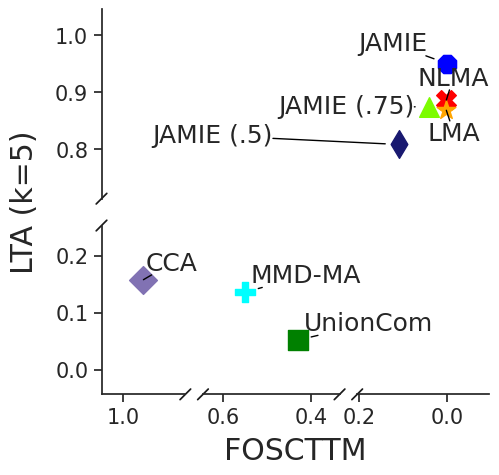

In [25]:
with_idx = [i for i in range(len(integrated_data)) if i not in (1, 2)]
# Without Partial
plt.figure(figsize=(5, 5))
idx = with_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx], expand_points=(2., 2.))
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Acc.svg', format='svg', bbox_inches='tight')

without_idx = list(range(len(integrated_data)))
# With Partial
plt.figure(figsize=(5, 5))
idx = without_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPartial.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccPartial.svg', format='svg', bbox_inches='tight')

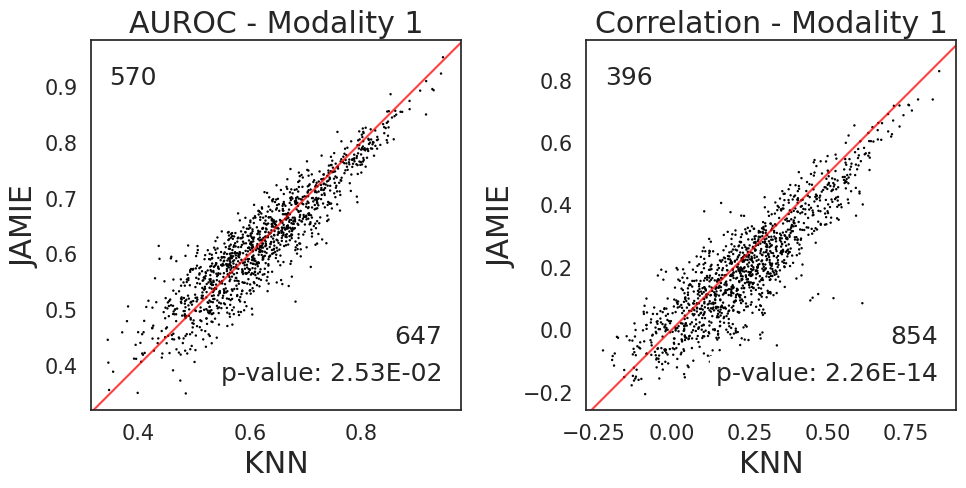

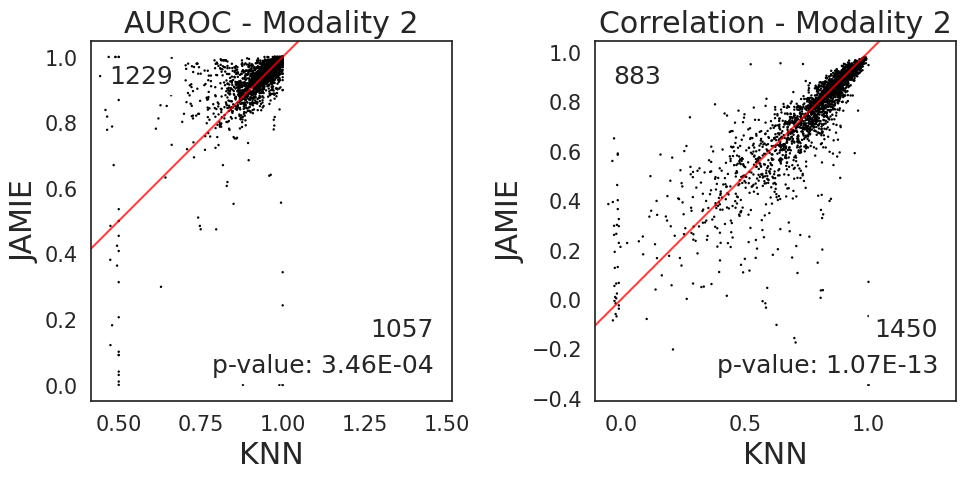

In [26]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2.svg', format='svg', bbox_inches='tight')

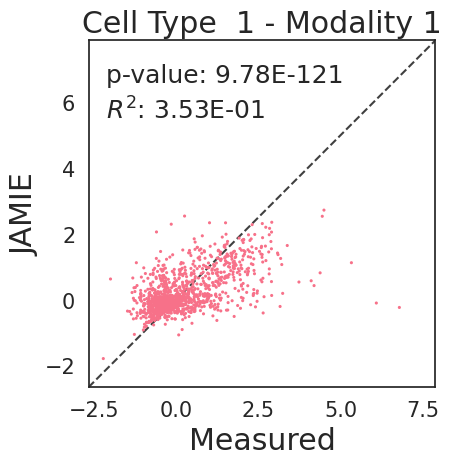

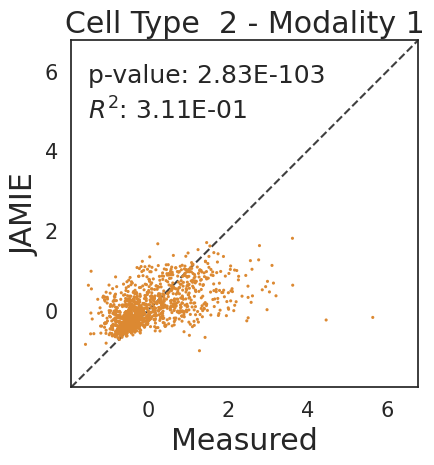

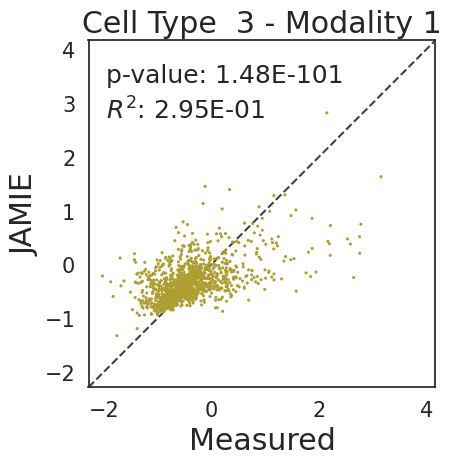

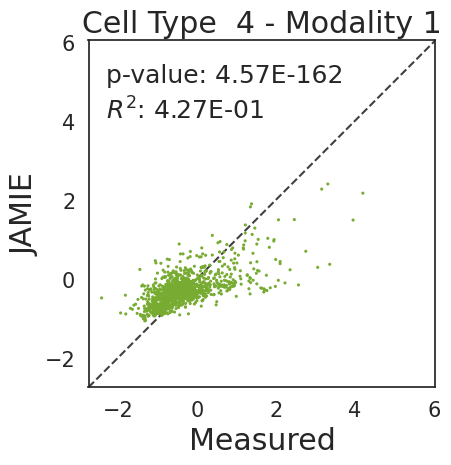

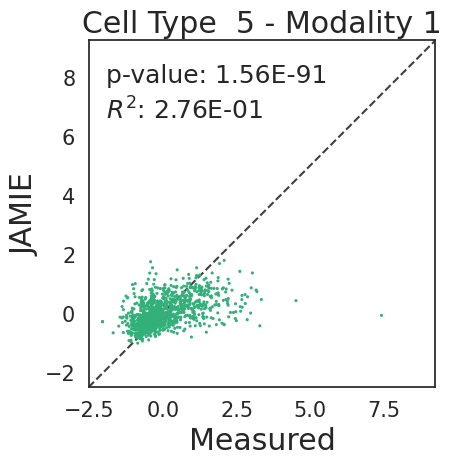

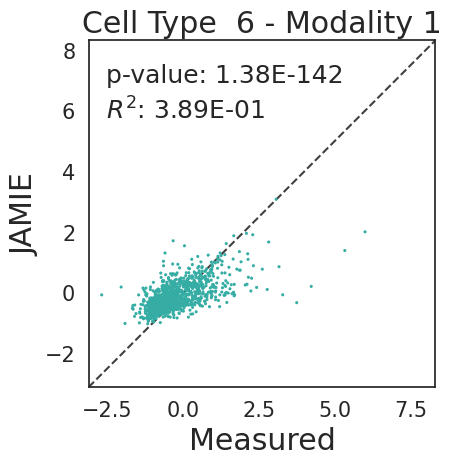

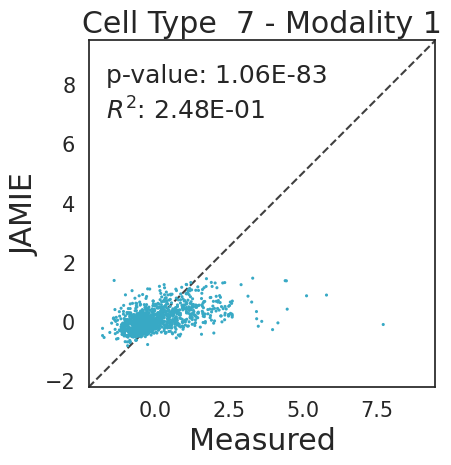

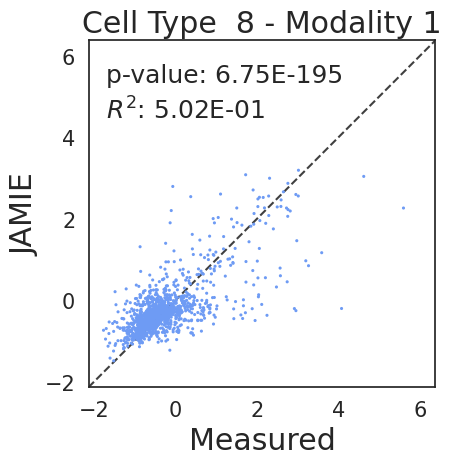

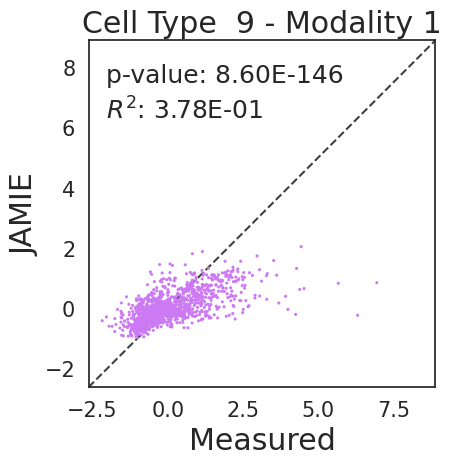

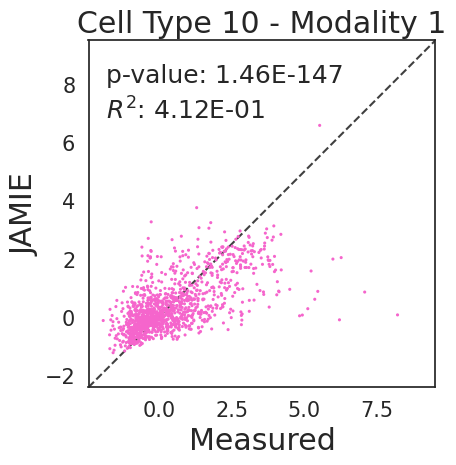

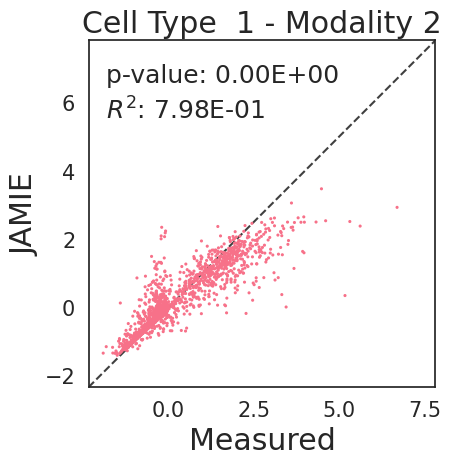

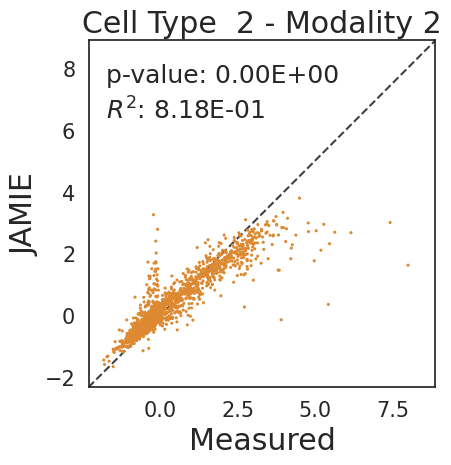

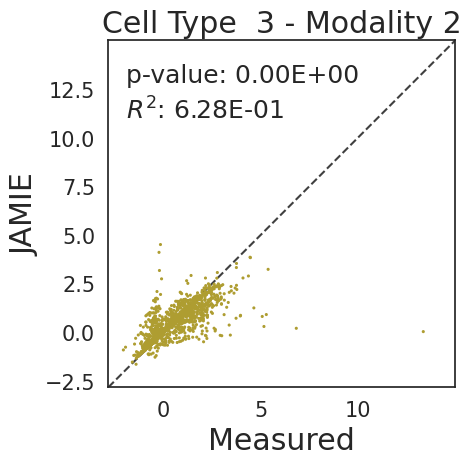

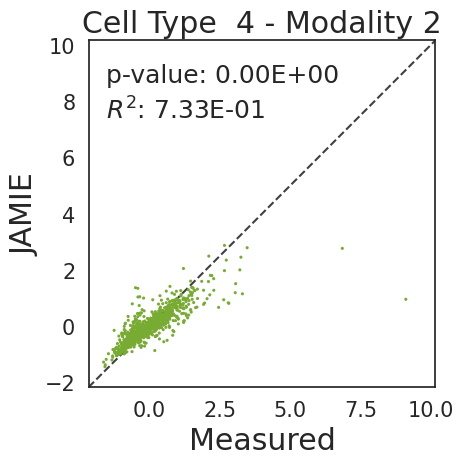

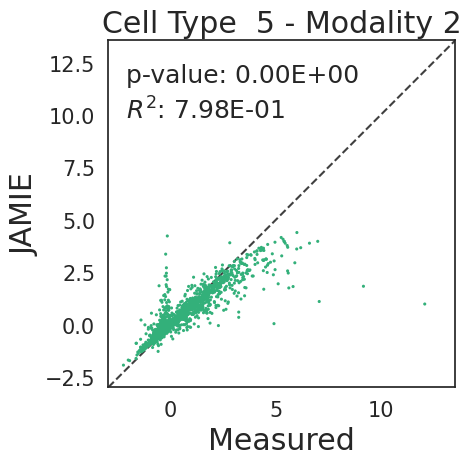

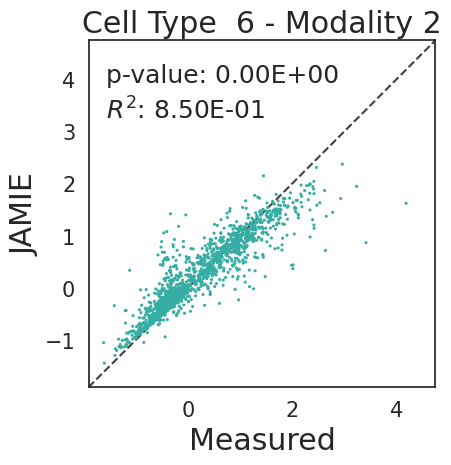

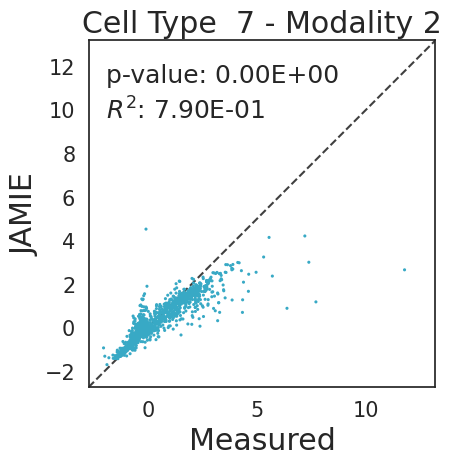

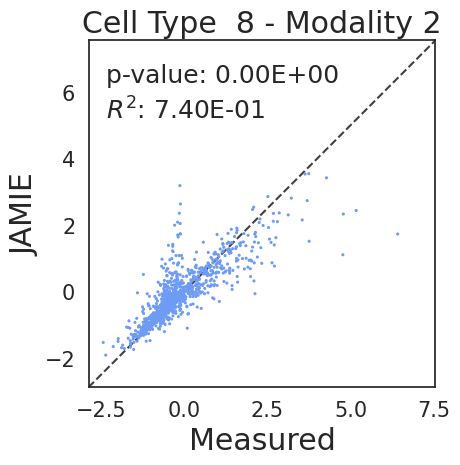

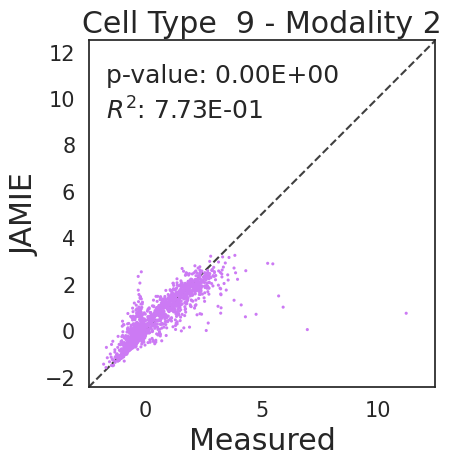

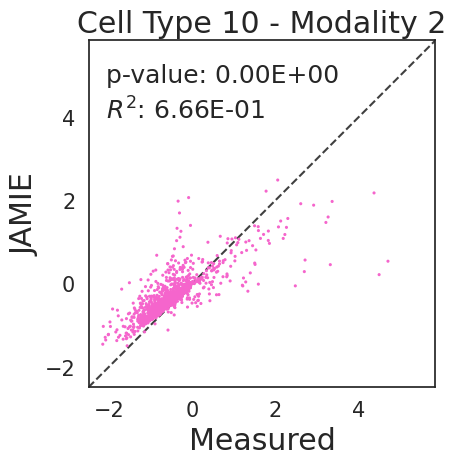

In [27]:
# Choose sample
for modality_idx in range(len(dataset)):
    for i, cell_type in enumerate(np.unique(labels[modality_idx][test_idx])):
        plt.figure(figsize=(5, 5))
        plot_sample(
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], dataset[modality_idx][test_idx]) if ct==cell_type]),
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], imputed_data[1][modality_idx]) if ct==cell_type]),
            imputed_names[1],
            modality_names[modality_idx],
            suptitle=cell_type,
            color=np.array(plt.rcParams['axes.prop_cycle'])[i]['color'])
        plt.tight_layout()
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.svg', format='svg', bbox_inches='tight')
        plt.show()

Feature 879: 0.2857797657876955
Feature 279: 0.24735183535012148


/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Feature 1228: 0.2538352239457417
Feature 464: 0.239865510992717


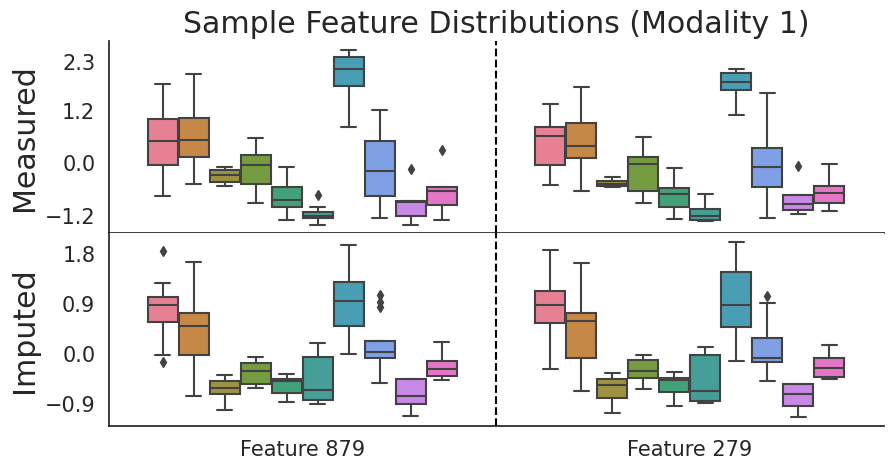

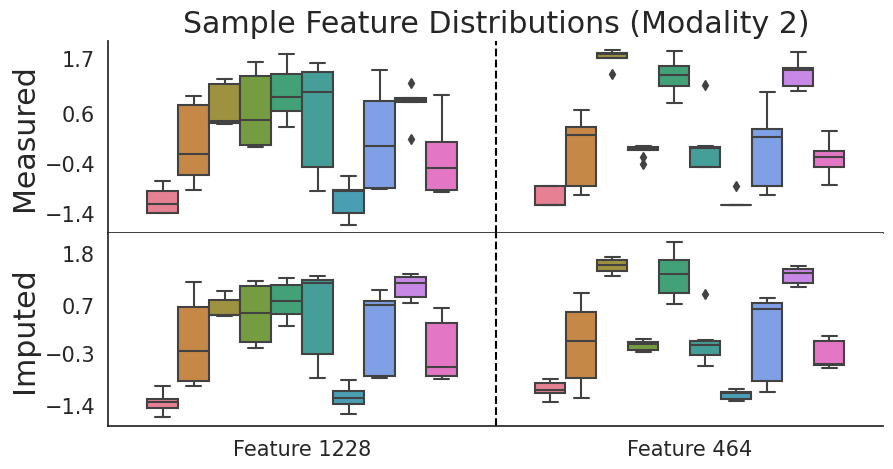

In [28]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist2.svg', format='svg', bbox_inches='tight')

Mean: 0.6093726160055194
Std: 0.13231005723508657
Mean: 0.34832987908157675
Std: 0.2538655681828716


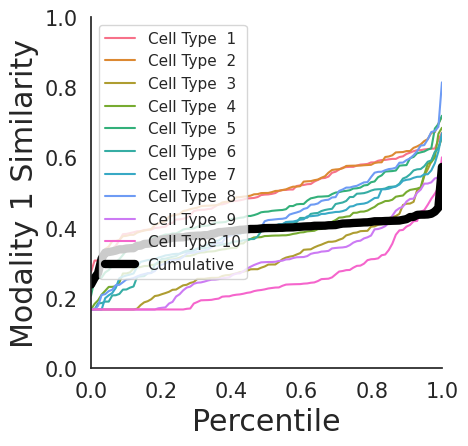

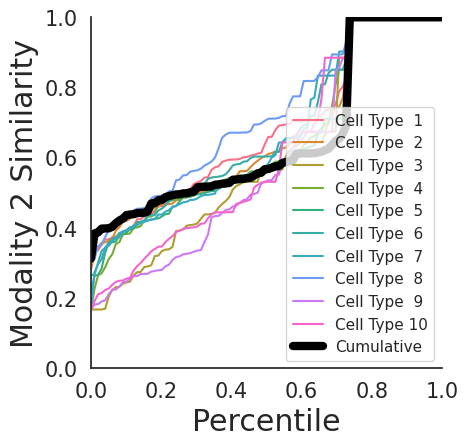

In [29]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim2.svg', format='svg', bbox_inches='tight')